In [1]:
# Import the required packages
import numpy as np
import pandas as po
import matplotlib
import matplotlib.pyplot  as plt
import scipy

In [2]:
# Display plots in notebook
%matplotlib inline
# Define plots default size
matplotlib.rcParams['figure.figsize'] = [10.0, 8.0]

In [3]:
# Read the data
full_data = po.read_csv('H:\Data\creditcard.csv')

In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
# Selecting random locations for training datasets
full_data['is_train'] = np.random.uniform(0, 1, len(full_data)) <= .8
# Filtering data based in train_index locations
train = full_data.loc[full_data['is_train']==True, :]
# Drop the index
test = full_data.loc[full_data['is_train']==False, :]


del full_data['is_train']
del train['is_train']
del test['is_train']

del full_data['Time']
del train['Time']
del test['Time']

del full_data['Amount']
del train['Amount']
del test['Amount']

In [27]:
X, y = np.array(train.iloc[:,0:27]) , np.array(train.iloc[:,28])

In [7]:
X.shape

(227996, 27)

In [8]:
y.shape

(227996,)

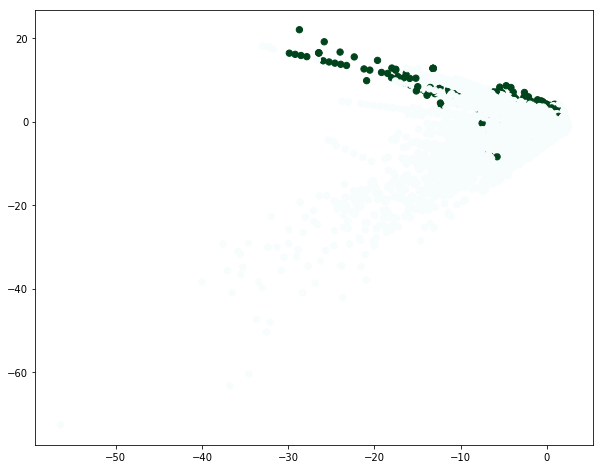

In [9]:
plt.scatter(X[:,0], X[:,1], s = 40, c = y, cmap = plt.cm.BuGn)

# Start building the MLP model blocks

In [10]:
import random
random.seed(123)

def rand(a, b):
    return (b - a)*random.random() + a

In [11]:
# Make the matrix
def makeMatrix(I, J, fill = 0.0):
    return np.zeros([I,J])

In [12]:
# Activation Function = Sigmoid Function
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [13]:
# Derivative Function
def dsigmoid(y):
    return y - y**2

In [14]:
# Neural Netork Class

# Putting all together

class MLP:
    def __init__(self, ni, nh, no):
        # number of input, hidden, and output nodes
        self.ni = ni + 1 # +1 for bias node
        self.nh = nh
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        
        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)

        # last change in weights for momentum   
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)
        

    def backPropagate(self, targets, N, M):
        
        if len(targets) != self.no:
            print(targets)
            raise ValueError('wrong number of target values')

        # calculate error terms for output
        output_deltas = np.zeros(self.no)
        for k in range(self.no):
            error = targets[k]-self.ao[k]
            output_deltas[k] = dsigmoid(self.ao[k]) * error

        # calculate error terms for hidden
        hidden_deltas = np.zeros(self.nh)
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error += output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # update output weights
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k] * self.ah[j]
                self.wo[j][k] += N*change + M*self.co[j][k]
                self.co[j][k] = change

        # update input weights
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] += N*change + M*self.ci[i][j]
                self.ci[i][j] = change

        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error += 0.5*(targets[k]-self.ao[k])**2
        return error


    def test(self, patterns):
        self.predict = np.empty([len(patterns), self.no])
        for i, p in enumerate(patterns):
            self.predict[i] = self.activate(p)
            #self.predict[i] = self.activate(p[0])
            
    def activate(self, inputs):
        
        if len(inputs) != self.ni-1:
            print(inputs)
            raise ValueError('wrong number of inputs')

        # input activations
        for i in range(self.ni-1):
            self.ai[i] = inputs[i]

        # hidden activations
        for j in range(self.nh):
            sum_h = 0.0
            for i in range(self.ni):
                sum_h += self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum_h)

        # output activations
        for k in range(self.no):
            sum_o = 0.0
            for j in range(self.nh):
                sum_o += self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum_o)

        return self.ao[:]
    

    def train(self, patterns, iterations=1000, N=0.5, M=0.1):
        # N: learning rate
        # M: momentum factor
        patterns = list(patterns)
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.activate(inputs)
                error += self.backPropagate([targets], N, M)
            if i % 5 == 0:
                print('error in interation %d : %-.5f' % (i,error))
            print('Final training error: %-.5f' % error)

### Running the model in our dataset

In [15]:
model = MLP(27, 10, 1)

%timeit -n 1 -r 1 model.train(zip(X,y), iterations = 10)

%timeit -n 1 -r 1 model.test(X)

error in interation 0 : 65.80058
Final training error: 65.80058
Final training error: 61.82788
Final training error: 61.56048
Final training error: 61.89330
Final training error: 60.53518
error in interation 5 : 58.61480
Final training error: 58.61480
Final training error: 59.27212
Final training error: 58.25812
Final training error: 57.92131
Final training error: 56.38983
1 loop, best of 1: 29min 18s per loop
1 loop, best of 1: 49.1 s per loop


In [16]:
prediction = po.DataFrame(data = np.array([y, np.ravel(model.predict)]).T, columns = ["Actual","Prediction"])
prediction.head()

,Actual,Prediction
0,0.0,8.277507e-06
1,0.0,1.319558e-05
2,0.0,7.857611e-07
3,0.0,1.449796e-06
4,0.0,4.508472e-07


In [22]:
prediction['Diff'] = prediction['Actual'] - prediction['Prediction']
np.max(prediction.Diff)

0.99999962251026064